# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

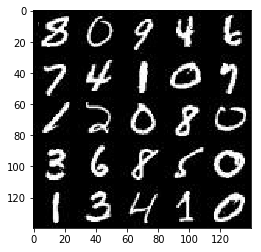

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

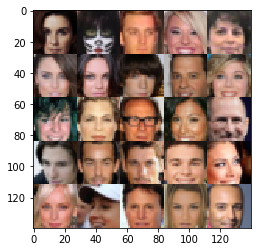

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [119]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real   = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [120]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x#ch
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(x1.shape)
        
        # 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [178]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator',reuse= not is_train):#False if is_train else True):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        #print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 4x4x256 now
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)
        # 4x4x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x#ch now
        
        out = tf.tanh(logits)
        #print(out.shape)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [179]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [180]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [181]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [184]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Sizeget_batches
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    steps = 0
    show_every = 50
    print_every = 10
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images *= 2
            
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.2409... Generator Loss: 11.8783
Epoch 0/2... Discriminator Loss: 0.3550... Generator Loss: 1.3494
Epoch 0/2... Discriminator Loss: 0.4406... Generator Loss: 20.4989
Epoch 0/2... Discriminator Loss: 0.0295... Generator Loss: 11.9997


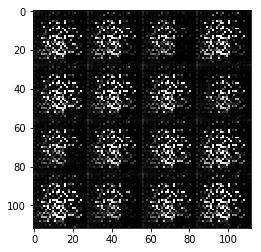

Epoch 0/2... Discriminator Loss: 0.9595... Generator Loss: 17.1762
Epoch 0/2... Discriminator Loss: 0.9271... Generator Loss: 14.1004
Epoch 0/2... Discriminator Loss: 2.4104... Generator Loss: 0.5187
Epoch 0/2... Discriminator Loss: 0.2604... Generator Loss: 3.1001
Epoch 0/2... Discriminator Loss: 0.2138... Generator Loss: 2.7509


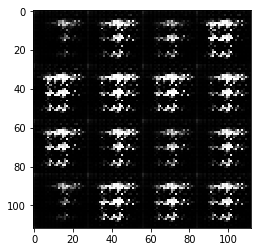

Epoch 0/2... Discriminator Loss: 0.2169... Generator Loss: 3.3572
Epoch 0/2... Discriminator Loss: 0.2591... Generator Loss: 2.1629
Epoch 0/2... Discriminator Loss: 0.0627... Generator Loss: 5.5722
Epoch 0/2... Discriminator Loss: 0.8061... Generator Loss: 0.7990
Epoch 0/2... Discriminator Loss: 0.6866... Generator Loss: 2.3167


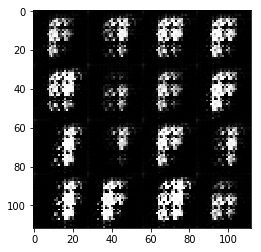

Epoch 0/2... Discriminator Loss: 0.2443... Generator Loss: 2.3091
Epoch 0/2... Discriminator Loss: 0.0863... Generator Loss: 3.5495
Epoch 0/2... Discriminator Loss: 0.0383... Generator Loss: 4.1279
Epoch 0/2... Discriminator Loss: 0.0991... Generator Loss: 3.5354
Epoch 0/2... Discriminator Loss: 0.0367... Generator Loss: 6.5128


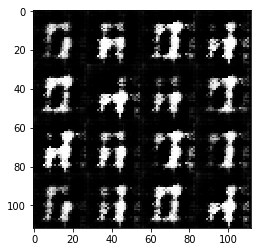

Epoch 0/2... Discriminator Loss: 0.7803... Generator Loss: 1.1451
Epoch 0/2... Discriminator Loss: 0.6918... Generator Loss: 0.8146
Epoch 0/2... Discriminator Loss: 0.4230... Generator Loss: 2.4830
Epoch 0/2... Discriminator Loss: 0.2545... Generator Loss: 2.2855
Epoch 0/2... Discriminator Loss: 0.2391... Generator Loss: 2.4015


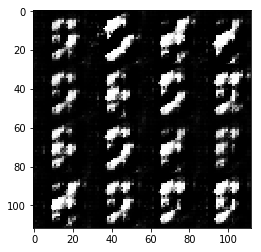

Epoch 0/2... Discriminator Loss: 0.1880... Generator Loss: 2.5425
Epoch 0/2... Discriminator Loss: 0.1281... Generator Loss: 3.0446
Epoch 0/2... Discriminator Loss: 0.3128... Generator Loss: 2.1313
Epoch 0/2... Discriminator Loss: 0.1656... Generator Loss: 3.4634
Epoch 0/2... Discriminator Loss: 0.1687... Generator Loss: 4.9551


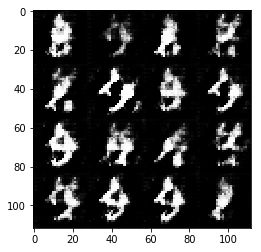

Epoch 0/2... Discriminator Loss: 0.1975... Generator Loss: 3.0526
Epoch 0/2... Discriminator Loss: 0.6809... Generator Loss: 1.5182
Epoch 0/2... Discriminator Loss: 0.5071... Generator Loss: 1.5526
Epoch 0/2... Discriminator Loss: 0.2093... Generator Loss: 3.8539
Epoch 0/2... Discriminator Loss: 0.2785... Generator Loss: 3.6722


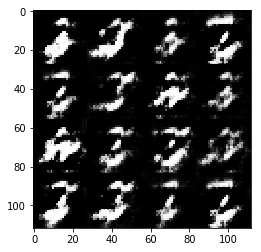

Epoch 0/2... Discriminator Loss: 0.1588... Generator Loss: 4.1333
Epoch 0/2... Discriminator Loss: 0.1733... Generator Loss: 3.4480
Epoch 0/2... Discriminator Loss: 0.1444... Generator Loss: 3.5890
Epoch 0/2... Discriminator Loss: 0.2906... Generator Loss: 3.2604
Epoch 0/2... Discriminator Loss: 0.5089... Generator Loss: 1.3450


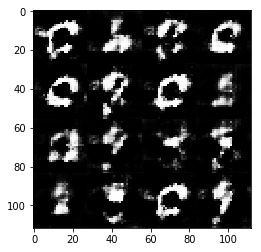

Epoch 0/2... Discriminator Loss: 0.2698... Generator Loss: 4.4973
Epoch 0/2... Discriminator Loss: 0.2661... Generator Loss: 2.9081
Epoch 0/2... Discriminator Loss: 0.2204... Generator Loss: 2.9542
Epoch 0/2... Discriminator Loss: 0.5044... Generator Loss: 2.7219
Epoch 0/2... Discriminator Loss: 0.5516... Generator Loss: 1.7201


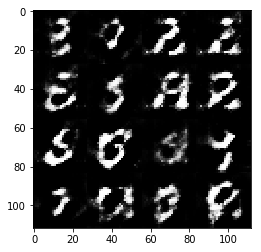

Epoch 0/2... Discriminator Loss: 0.4311... Generator Loss: 1.7427
Epoch 0/2... Discriminator Loss: 0.3955... Generator Loss: 2.9074
Epoch 0/2... Discriminator Loss: 2.4268... Generator Loss: 7.5783
Epoch 0/2... Discriminator Loss: 0.9490... Generator Loss: 0.8057
Epoch 0/2... Discriminator Loss: 0.4936... Generator Loss: 1.7357


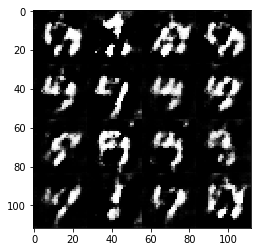

Epoch 0/2... Discriminator Loss: 0.3894... Generator Loss: 2.1009
Epoch 0/2... Discriminator Loss: 0.2617... Generator Loss: 2.6830
Epoch 0/2... Discriminator Loss: 0.8465... Generator Loss: 1.5795
Epoch 0/2... Discriminator Loss: 0.9072... Generator Loss: 1.2294
Epoch 0/2... Discriminator Loss: 0.4195... Generator Loss: 2.2955


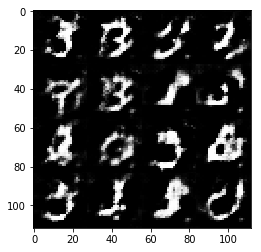

Epoch 0/2... Discriminator Loss: 0.3492... Generator Loss: 2.0822
Epoch 0/2... Discriminator Loss: 0.4411... Generator Loss: 3.1776
Epoch 0/2... Discriminator Loss: 0.8271... Generator Loss: 5.3305
Epoch 0/2... Discriminator Loss: 0.4230... Generator Loss: 2.1326
Epoch 0/2... Discriminator Loss: 1.0609... Generator Loss: 0.8626


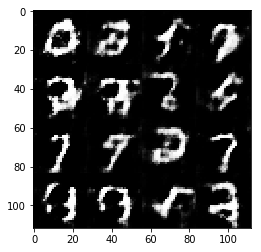

Epoch 0/2... Discriminator Loss: 0.5416... Generator Loss: 1.4667
Epoch 0/2... Discriminator Loss: 0.5251... Generator Loss: 1.6667
Epoch 0/2... Discriminator Loss: 0.5803... Generator Loss: 2.8510
Epoch 0/2... Discriminator Loss: 0.7665... Generator Loss: 1.1054
Epoch 0/2... Discriminator Loss: 0.9601... Generator Loss: 1.1563


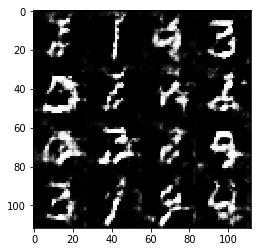

Epoch 0/2... Discriminator Loss: 0.9105... Generator Loss: 3.4657
Epoch 0/2... Discriminator Loss: 0.6512... Generator Loss: 2.6798
Epoch 0/2... Discriminator Loss: 0.8013... Generator Loss: 2.0114
Epoch 0/2... Discriminator Loss: 0.6375... Generator Loss: 1.8240
Epoch 0/2... Discriminator Loss: 0.8705... Generator Loss: 1.8876


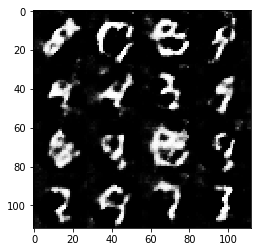

Epoch 0/2... Discriminator Loss: 0.6479... Generator Loss: 1.6197
Epoch 0/2... Discriminator Loss: 0.6355... Generator Loss: 1.6573
Epoch 0/2... Discriminator Loss: 0.6192... Generator Loss: 1.5580
Epoch 0/2... Discriminator Loss: 0.6580... Generator Loss: 1.4334
Epoch 0/2... Discriminator Loss: 0.6630... Generator Loss: 1.3089


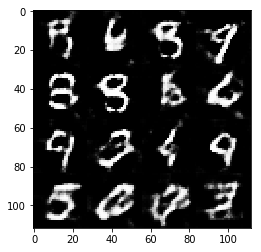

Epoch 0/2... Discriminator Loss: 0.5396... Generator Loss: 1.5576
Epoch 0/2... Discriminator Loss: 0.9123... Generator Loss: 0.8101
Epoch 0/2... Discriminator Loss: 0.5459... Generator Loss: 1.4982
Epoch 0/2... Discriminator Loss: 0.5795... Generator Loss: 1.6804
Epoch 0/2... Discriminator Loss: 0.5953... Generator Loss: 2.2447


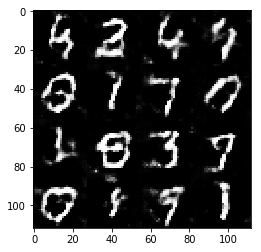

Epoch 0/2... Discriminator Loss: 0.6226... Generator Loss: 1.6053
Epoch 0/2... Discriminator Loss: 0.9898... Generator Loss: 0.7476
Epoch 0/2... Discriminator Loss: 0.6588... Generator Loss: 1.4593
Epoch 0/2... Discriminator Loss: 0.6466... Generator Loss: 1.7195
Epoch 0/2... Discriminator Loss: 0.6174... Generator Loss: 2.3231


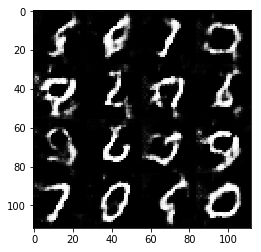

Epoch 0/2... Discriminator Loss: 0.8400... Generator Loss: 1.0188
Epoch 0/2... Discriminator Loss: 0.4630... Generator Loss: 1.9605
Epoch 0/2... Discriminator Loss: 0.7402... Generator Loss: 0.9497
Epoch 0/2... Discriminator Loss: 0.7103... Generator Loss: 2.0320
Epoch 0/2... Discriminator Loss: 0.6409... Generator Loss: 1.6001


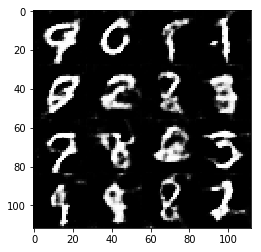

Epoch 0/2... Discriminator Loss: 0.5369... Generator Loss: 2.7404
Epoch 0/2... Discriminator Loss: 1.1060... Generator Loss: 0.6743
Epoch 0/2... Discriminator Loss: 1.2468... Generator Loss: 0.5595
Epoch 0/2... Discriminator Loss: 0.5742... Generator Loss: 1.7418
Epoch 1/2... Discriminator Loss: 0.6643... Generator Loss: 1.1798


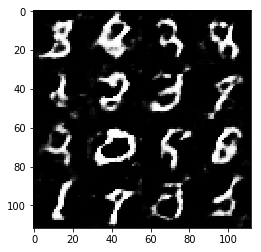

Epoch 1/2... Discriminator Loss: 0.6695... Generator Loss: 1.1874
Epoch 1/2... Discriminator Loss: 0.6817... Generator Loss: 1.2042
Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 0.4822
Epoch 1/2... Discriminator Loss: 0.6490... Generator Loss: 1.7642
Epoch 1/2... Discriminator Loss: 0.7062... Generator Loss: 1.0352


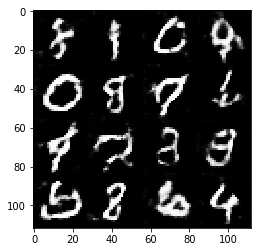

Epoch 1/2... Discriminator Loss: 0.7781... Generator Loss: 1.4136
Epoch 1/2... Discriminator Loss: 0.8690... Generator Loss: 2.0737
Epoch 1/2... Discriminator Loss: 0.5290... Generator Loss: 1.8966
Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 0.5830
Epoch 1/2... Discriminator Loss: 0.5911... Generator Loss: 1.4688


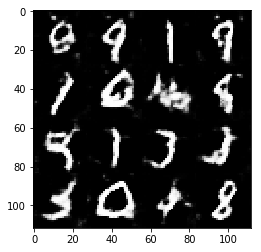

Epoch 1/2... Discriminator Loss: 0.7824... Generator Loss: 1.6854
Epoch 1/2... Discriminator Loss: 0.7462... Generator Loss: 2.1099
Epoch 1/2... Discriminator Loss: 0.5616... Generator Loss: 1.3078
Epoch 1/2... Discriminator Loss: 0.4835... Generator Loss: 1.5197
Epoch 1/2... Discriminator Loss: 0.8815... Generator Loss: 2.0554


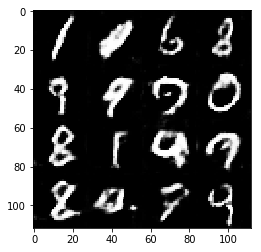

Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 0.8173
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 0.8014
Epoch 1/2... Discriminator Loss: 0.8809... Generator Loss: 0.7645
Epoch 1/2... Discriminator Loss: 0.5768... Generator Loss: 1.2970
Epoch 1/2... Discriminator Loss: 2.2081... Generator Loss: 3.4007


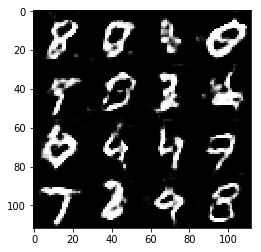

Epoch 1/2... Discriminator Loss: 0.7888... Generator Loss: 1.5248
Epoch 1/2... Discriminator Loss: 0.7480... Generator Loss: 2.0522
Epoch 1/2... Discriminator Loss: 0.7770... Generator Loss: 0.9507
Epoch 1/2... Discriminator Loss: 0.8554... Generator Loss: 0.9560
Epoch 1/2... Discriminator Loss: 1.0409... Generator Loss: 0.6632


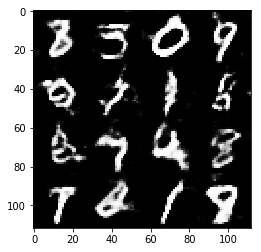

Epoch 1/2... Discriminator Loss: 1.0726... Generator Loss: 0.5587
Epoch 1/2... Discriminator Loss: 0.8827... Generator Loss: 0.7432
Epoch 1/2... Discriminator Loss: 0.7785... Generator Loss: 0.8931
Epoch 1/2... Discriminator Loss: 0.6990... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 2.0714... Generator Loss: 3.0346


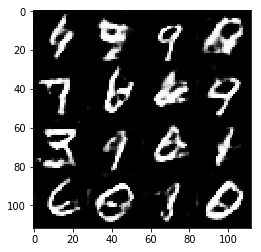

Epoch 1/2... Discriminator Loss: 0.7471... Generator Loss: 1.1644
Epoch 1/2... Discriminator Loss: 0.6585... Generator Loss: 1.3708
Epoch 1/2... Discriminator Loss: 0.8506... Generator Loss: 0.7412
Epoch 1/2... Discriminator Loss: 2.3757... Generator Loss: 4.3007
Epoch 1/2... Discriminator Loss: 0.8165... Generator Loss: 0.7989


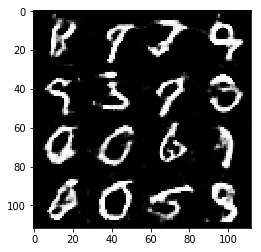

Epoch 1/2... Discriminator Loss: 0.7377... Generator Loss: 1.6182
Epoch 1/2... Discriminator Loss: 1.0738... Generator Loss: 0.9118
Epoch 1/2... Discriminator Loss: 1.0083... Generator Loss: 0.7216
Epoch 1/2... Discriminator Loss: 0.9634... Generator Loss: 0.6595
Epoch 1/2... Discriminator Loss: 1.2068... Generator Loss: 0.5636


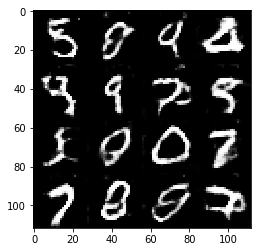

Epoch 1/2... Discriminator Loss: 0.7257... Generator Loss: 0.9150
Epoch 1/2... Discriminator Loss: 1.3367... Generator Loss: 2.3957
Epoch 1/2... Discriminator Loss: 0.7738... Generator Loss: 1.0119
Epoch 1/2... Discriminator Loss: 0.6645... Generator Loss: 1.3260
Epoch 1/2... Discriminator Loss: 1.1950... Generator Loss: 0.5338


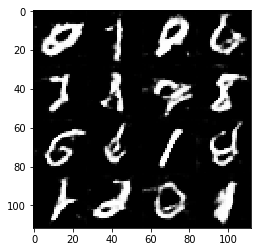

Epoch 1/2... Discriminator Loss: 0.8680... Generator Loss: 0.7673
Epoch 1/2... Discriminator Loss: 1.0266... Generator Loss: 0.6378
Epoch 1/2... Discriminator Loss: 1.1741... Generator Loss: 2.3177
Epoch 1/2... Discriminator Loss: 0.9258... Generator Loss: 0.9209
Epoch 1/2... Discriminator Loss: 0.5438... Generator Loss: 2.3233


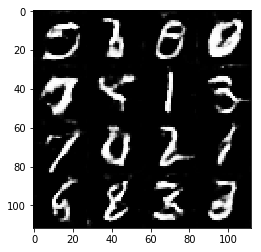

Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 0.9602
Epoch 1/2... Discriminator Loss: 0.5948... Generator Loss: 1.5336
Epoch 1/2... Discriminator Loss: 0.8821... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 0.8941... Generator Loss: 2.1747
Epoch 1/2... Discriminator Loss: 0.9299... Generator Loss: 1.6206


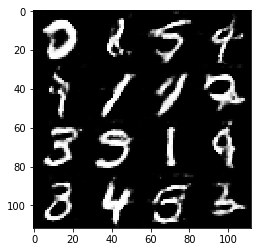

Epoch 1/2... Discriminator Loss: 1.2172... Generator Loss: 0.5229
Epoch 1/2... Discriminator Loss: 0.9131... Generator Loss: 2.0195
Epoch 1/2... Discriminator Loss: 0.5990... Generator Loss: 1.4965
Epoch 1/2... Discriminator Loss: 0.8138... Generator Loss: 0.8350
Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 0.9446


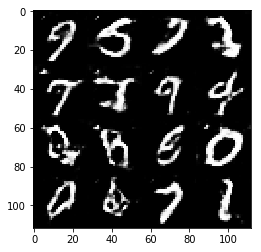

Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 0.4743
Epoch 1/2... Discriminator Loss: 0.8351... Generator Loss: 1.0234
Epoch 1/2... Discriminator Loss: 0.5491... Generator Loss: 1.3181
Epoch 1/2... Discriminator Loss: 0.7778... Generator Loss: 0.9869
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 0.6456


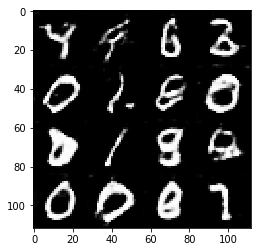

Epoch 1/2... Discriminator Loss: 0.9338... Generator Loss: 0.7526
Epoch 1/2... Discriminator Loss: 0.7346... Generator Loss: 0.9390
Epoch 1/2... Discriminator Loss: 0.7642... Generator Loss: 1.4069
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.4297
Epoch 1/2... Discriminator Loss: 0.8516... Generator Loss: 0.8130


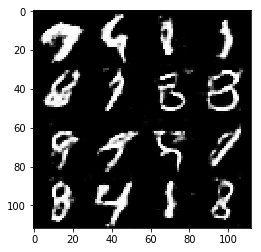

Epoch 1/2... Discriminator Loss: 0.5220... Generator Loss: 1.4085
Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 1.3255
Epoch 1/2... Discriminator Loss: 1.6161... Generator Loss: 2.4491
Epoch 1/2... Discriminator Loss: 1.1068... Generator Loss: 2.3841
Epoch 1/2... Discriminator Loss: 0.9877... Generator Loss: 0.7009


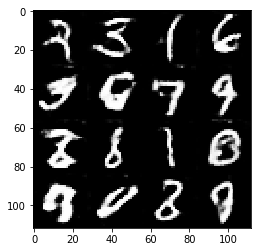

Epoch 1/2... Discriminator Loss: 0.6910... Generator Loss: 1.7495
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 0.6540... Generator Loss: 1.2337
Epoch 1/2... Discriminator Loss: 0.9806... Generator Loss: 0.6639
Epoch 1/2... Discriminator Loss: 0.6695... Generator Loss: 0.9936


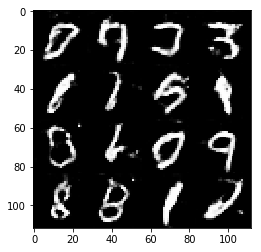

Epoch 1/2... Discriminator Loss: 1.5307... Generator Loss: 0.3482
Epoch 1/2... Discriminator Loss: 0.9099... Generator Loss: 0.8515
Epoch 1/2... Discriminator Loss: 0.8384... Generator Loss: 1.7707
Epoch 1/2... Discriminator Loss: 0.7447... Generator Loss: 1.0155
Epoch 1/2... Discriminator Loss: 0.7459... Generator Loss: 0.9674


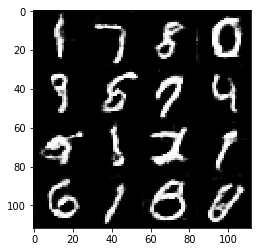

Epoch 1/2... Discriminator Loss: 1.4714... Generator Loss: 2.9896
Epoch 1/2... Discriminator Loss: 0.6516... Generator Loss: 1.0187
Epoch 1/2... Discriminator Loss: 2.2020... Generator Loss: 4.3986
Epoch 1/2... Discriminator Loss: 0.5608... Generator Loss: 1.3916
Epoch 1/2... Discriminator Loss: 0.8291... Generator Loss: 0.7738


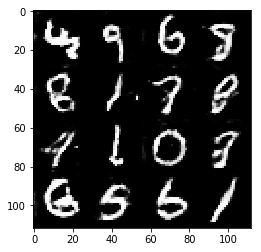

Epoch 1/2... Discriminator Loss: 0.8221... Generator Loss: 0.7973
Epoch 1/2... Discriminator Loss: 0.7691... Generator Loss: 0.8714
Epoch 1/2... Discriminator Loss: 1.5412... Generator Loss: 0.3639


In [185]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.2637... Generator Loss: 2.4330
Epoch 0/1... Discriminator Loss: 0.1277... Generator Loss: 8.1301
Epoch 0/1... Discriminator Loss: 0.0601... Generator Loss: 9.4240
Epoch 0/1... Discriminator Loss: 0.0903... Generator Loss: 15.2095


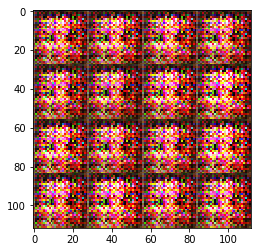

Epoch 0/1... Discriminator Loss: 0.9006... Generator Loss: 15.6984
Epoch 0/1... Discriminator Loss: 2.6353... Generator Loss: 14.0384
Epoch 0/1... Discriminator Loss: 0.7512... Generator Loss: 5.0159
Epoch 0/1... Discriminator Loss: 1.0552... Generator Loss: 6.6704
Epoch 0/1... Discriminator Loss: 0.5390... Generator Loss: 4.1185


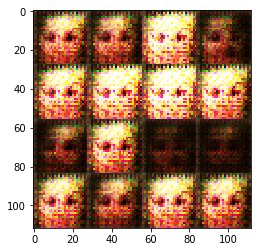

Epoch 0/1... Discriminator Loss: 0.4405... Generator Loss: 1.7515
Epoch 0/1... Discriminator Loss: 0.9726... Generator Loss: 8.0968
Epoch 0/1... Discriminator Loss: 0.1750... Generator Loss: 4.9822
Epoch 0/1... Discriminator Loss: 0.3213... Generator Loss: 4.1436
Epoch 0/1... Discriminator Loss: 0.3516... Generator Loss: 2.0285


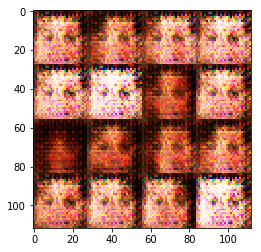

Epoch 0/1... Discriminator Loss: 0.3488... Generator Loss: 1.4962
Epoch 0/1... Discriminator Loss: 0.9043... Generator Loss: 0.7705
Epoch 0/1... Discriminator Loss: 0.5820... Generator Loss: 2.5639
Epoch 0/1... Discriminator Loss: 1.5956... Generator Loss: 6.6273
Epoch 0/1... Discriminator Loss: 0.4061... Generator Loss: 2.6980


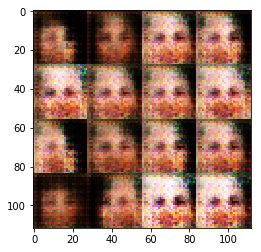

Epoch 0/1... Discriminator Loss: 0.4703... Generator Loss: 2.2542
Epoch 0/1... Discriminator Loss: 0.8233... Generator Loss: 2.2257
Epoch 0/1... Discriminator Loss: 1.1659... Generator Loss: 0.5947
Epoch 0/1... Discriminator Loss: 1.0567... Generator Loss: 2.5929
Epoch 0/1... Discriminator Loss: 0.7846... Generator Loss: 2.5256


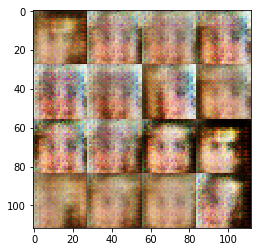

Epoch 0/1... Discriminator Loss: 1.4646... Generator Loss: 0.8144
Epoch 0/1... Discriminator Loss: 1.1811... Generator Loss: 1.3254
Epoch 0/1... Discriminator Loss: 1.1387... Generator Loss: 0.9972
Epoch 0/1... Discriminator Loss: 1.6123... Generator Loss: 0.3996
Epoch 0/1... Discriminator Loss: 1.1771... Generator Loss: 0.8855


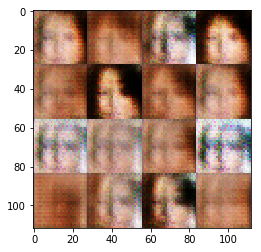

Epoch 0/1... Discriminator Loss: 0.9859... Generator Loss: 1.2389
Epoch 0/1... Discriminator Loss: 1.2961... Generator Loss: 0.9427
Epoch 0/1... Discriminator Loss: 1.0888... Generator Loss: 1.5554
Epoch 0/1... Discriminator Loss: 0.9928... Generator Loss: 1.4515
Epoch 0/1... Discriminator Loss: 0.9796... Generator Loss: 1.4308


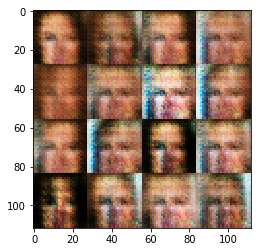

Epoch 0/1... Discriminator Loss: 0.9089... Generator Loss: 1.5790
Epoch 0/1... Discriminator Loss: 0.8682... Generator Loss: 0.9649
Epoch 0/1... Discriminator Loss: 1.7067... Generator Loss: 0.4714
Epoch 0/1... Discriminator Loss: 0.8747... Generator Loss: 0.9948
Epoch 0/1... Discriminator Loss: 0.9777... Generator Loss: 1.3066


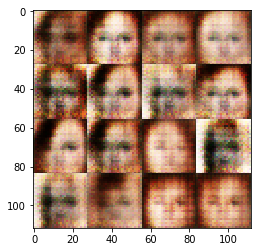

Epoch 0/1... Discriminator Loss: 1.2513... Generator Loss: 1.2079
Epoch 0/1... Discriminator Loss: 1.1143... Generator Loss: 1.5556
Epoch 0/1... Discriminator Loss: 0.8707... Generator Loss: 1.1037
Epoch 0/1... Discriminator Loss: 0.8767... Generator Loss: 1.2436
Epoch 0/1... Discriminator Loss: 0.9738... Generator Loss: 0.7663


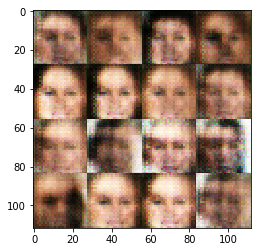

Epoch 0/1... Discriminator Loss: 1.6188... Generator Loss: 0.7407
Epoch 0/1... Discriminator Loss: 0.8337... Generator Loss: 1.0736
Epoch 0/1... Discriminator Loss: 1.0983... Generator Loss: 2.1694
Epoch 0/1... Discriminator Loss: 1.0292... Generator Loss: 1.3224
Epoch 0/1... Discriminator Loss: 1.8001... Generator Loss: 0.3075


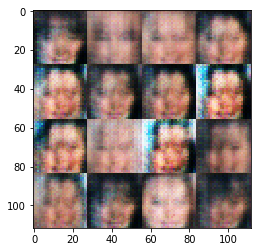

Epoch 0/1... Discriminator Loss: 1.1637... Generator Loss: 0.7309
Epoch 0/1... Discriminator Loss: 1.2384... Generator Loss: 0.7410
Epoch 0/1... Discriminator Loss: 1.1868... Generator Loss: 0.7454
Epoch 0/1... Discriminator Loss: 1.0730... Generator Loss: 0.8676
Epoch 0/1... Discriminator Loss: 1.0314... Generator Loss: 2.1329


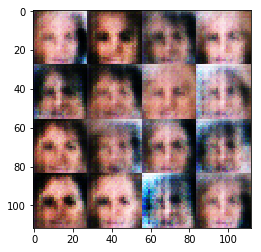

Epoch 0/1... Discriminator Loss: 0.9521... Generator Loss: 0.8589
Epoch 0/1... Discriminator Loss: 0.9870... Generator Loss: 0.9162
Epoch 0/1... Discriminator Loss: 0.6621... Generator Loss: 1.5166
Epoch 0/1... Discriminator Loss: 1.2865... Generator Loss: 0.6230
Epoch 0/1... Discriminator Loss: 0.8779... Generator Loss: 0.9480


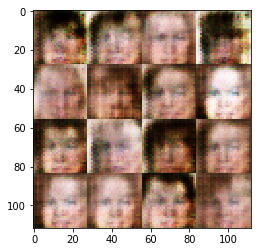

Epoch 0/1... Discriminator Loss: 1.3645... Generator Loss: 2.5059
Epoch 0/1... Discriminator Loss: 1.4976... Generator Loss: 0.4768
Epoch 0/1... Discriminator Loss: 0.7678... Generator Loss: 1.0924
Epoch 0/1... Discriminator Loss: 0.9583... Generator Loss: 1.3262
Epoch 0/1... Discriminator Loss: 0.7846... Generator Loss: 0.9574


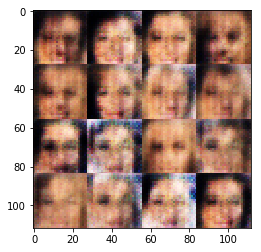

Epoch 0/1... Discriminator Loss: 1.1076... Generator Loss: 0.9768
Epoch 0/1... Discriminator Loss: 0.8475... Generator Loss: 1.0128
Epoch 0/1... Discriminator Loss: 1.1031... Generator Loss: 0.7751
Epoch 0/1... Discriminator Loss: 0.8347... Generator Loss: 1.7125
Epoch 0/1... Discriminator Loss: 0.7883... Generator Loss: 0.8811


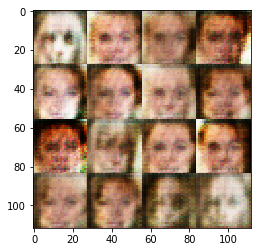

Epoch 0/1... Discriminator Loss: 0.8358... Generator Loss: 1.1556
Epoch 0/1... Discriminator Loss: 0.9620... Generator Loss: 0.9058
Epoch 0/1... Discriminator Loss: 0.6185... Generator Loss: 1.7981
Epoch 0/1... Discriminator Loss: 1.4458... Generator Loss: 0.5233
Epoch 0/1... Discriminator Loss: 0.9360... Generator Loss: 1.3806


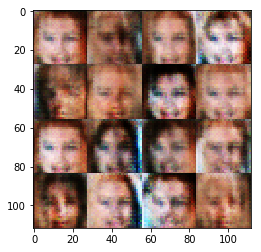

Epoch 0/1... Discriminator Loss: 0.8250... Generator Loss: 1.5819
Epoch 0/1... Discriminator Loss: 0.8115... Generator Loss: 1.7066
Epoch 0/1... Discriminator Loss: 1.2076... Generator Loss: 0.5722
Epoch 0/1... Discriminator Loss: 0.7092... Generator Loss: 1.5290
Epoch 0/1... Discriminator Loss: 0.9574... Generator Loss: 1.1173


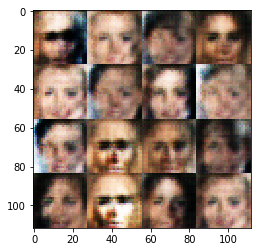

Epoch 0/1... Discriminator Loss: 0.8361... Generator Loss: 0.9060
Epoch 0/1... Discriminator Loss: 0.8238... Generator Loss: 1.3312
Epoch 0/1... Discriminator Loss: 0.8848... Generator Loss: 1.4521
Epoch 0/1... Discriminator Loss: 1.7409... Generator Loss: 3.7288
Epoch 0/1... Discriminator Loss: 0.9229... Generator Loss: 1.4778


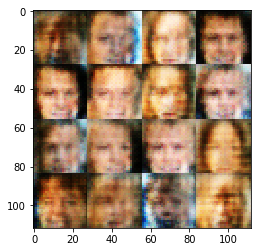

Epoch 0/1... Discriminator Loss: 0.9578... Generator Loss: 1.2551
Epoch 0/1... Discriminator Loss: 0.9421... Generator Loss: 2.2111
Epoch 0/1... Discriminator Loss: 0.7958... Generator Loss: 1.2300
Epoch 0/1... Discriminator Loss: 1.1098... Generator Loss: 0.6915
Epoch 0/1... Discriminator Loss: 0.9729... Generator Loss: 1.1111


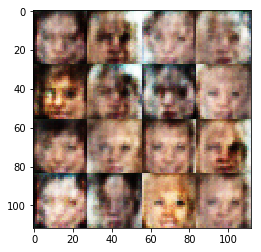

Epoch 0/1... Discriminator Loss: 1.0924... Generator Loss: 0.9024
Epoch 0/1... Discriminator Loss: 1.0151... Generator Loss: 1.2033
Epoch 0/1... Discriminator Loss: 0.8898... Generator Loss: 1.1250
Epoch 0/1... Discriminator Loss: 1.2203... Generator Loss: 0.6301
Epoch 0/1... Discriminator Loss: 0.8479... Generator Loss: 1.4121


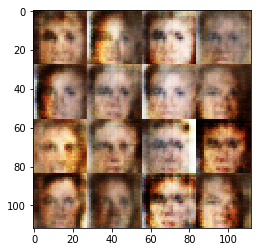

Epoch 0/1... Discriminator Loss: 1.1376... Generator Loss: 2.4439
Epoch 0/1... Discriminator Loss: 0.7100... Generator Loss: 1.0185
Epoch 0/1... Discriminator Loss: 1.6965... Generator Loss: 0.3211
Epoch 0/1... Discriminator Loss: 0.9261... Generator Loss: 1.2464
Epoch 0/1... Discriminator Loss: 0.9430... Generator Loss: 1.3156


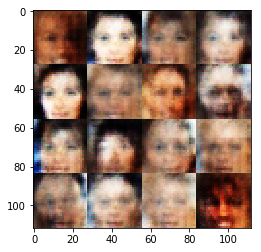

Epoch 0/1... Discriminator Loss: 0.7568... Generator Loss: 1.4862
Epoch 0/1... Discriminator Loss: 0.6109... Generator Loss: 1.5074
Epoch 0/1... Discriminator Loss: 1.3002... Generator Loss: 1.6929
Epoch 0/1... Discriminator Loss: 1.5709... Generator Loss: 0.3663
Epoch 0/1... Discriminator Loss: 0.8847... Generator Loss: 1.0051


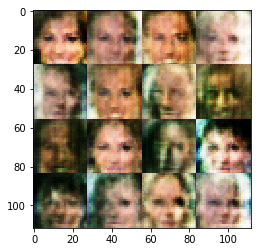

Epoch 0/1... Discriminator Loss: 1.0461... Generator Loss: 1.0776
Epoch 0/1... Discriminator Loss: 0.9899... Generator Loss: 0.7962
Epoch 0/1... Discriminator Loss: 1.1705... Generator Loss: 0.6147
Epoch 0/1... Discriminator Loss: 0.8320... Generator Loss: 1.4423
Epoch 0/1... Discriminator Loss: 0.7038... Generator Loss: 1.5328


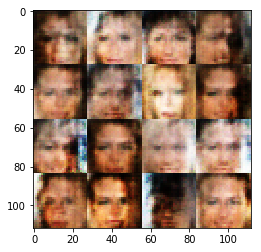

Epoch 0/1... Discriminator Loss: 1.0432... Generator Loss: 1.1147
Epoch 0/1... Discriminator Loss: 0.9516... Generator Loss: 0.9770
Epoch 0/1... Discriminator Loss: 1.2252... Generator Loss: 1.2928
Epoch 0/1... Discriminator Loss: 1.0140... Generator Loss: 1.5308
Epoch 0/1... Discriminator Loss: 1.2703... Generator Loss: 0.5049


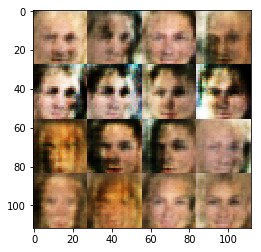

Epoch 0/1... Discriminator Loss: 0.9333... Generator Loss: 1.1775
Epoch 0/1... Discriminator Loss: 0.7969... Generator Loss: 1.4177
Epoch 0/1... Discriminator Loss: 0.7940... Generator Loss: 1.3967
Epoch 0/1... Discriminator Loss: 0.8246... Generator Loss: 2.0586
Epoch 0/1... Discriminator Loss: 0.9252... Generator Loss: 1.2416


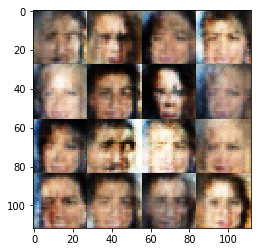

Epoch 0/1... Discriminator Loss: 0.9256... Generator Loss: 1.1705
Epoch 0/1... Discriminator Loss: 1.3160... Generator Loss: 0.4582
Epoch 0/1... Discriminator Loss: 1.1488... Generator Loss: 1.1578
Epoch 0/1... Discriminator Loss: 0.9747... Generator Loss: 0.9175
Epoch 0/1... Discriminator Loss: 1.5703... Generator Loss: 0.3809


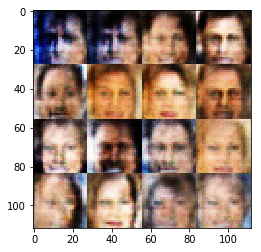

Epoch 0/1... Discriminator Loss: 1.1464... Generator Loss: 0.6387
Epoch 0/1... Discriminator Loss: 1.0172... Generator Loss: 0.8371
Epoch 0/1... Discriminator Loss: 0.9995... Generator Loss: 1.4611
Epoch 0/1... Discriminator Loss: 1.1546... Generator Loss: 0.7276
Epoch 0/1... Discriminator Loss: 1.2053... Generator Loss: 0.7635


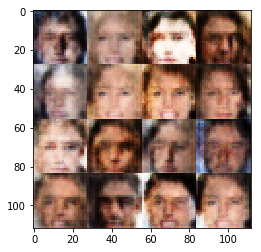

Epoch 0/1... Discriminator Loss: 0.8071... Generator Loss: 1.4890
Epoch 0/1... Discriminator Loss: 0.8321... Generator Loss: 1.6627
Epoch 0/1... Discriminator Loss: 0.8619... Generator Loss: 1.2466
Epoch 0/1... Discriminator Loss: 1.1783... Generator Loss: 0.6212
Epoch 0/1... Discriminator Loss: 0.9373... Generator Loss: 0.8230


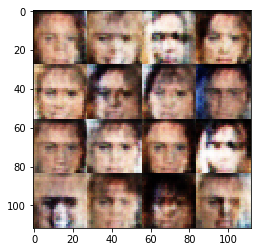

Epoch 0/1... Discriminator Loss: 1.1036... Generator Loss: 1.5677
Epoch 0/1... Discriminator Loss: 1.0129... Generator Loss: 1.2750
Epoch 0/1... Discriminator Loss: 1.0879... Generator Loss: 1.8148
Epoch 0/1... Discriminator Loss: 0.9314... Generator Loss: 1.7842
Epoch 0/1... Discriminator Loss: 1.1826... Generator Loss: 0.8412


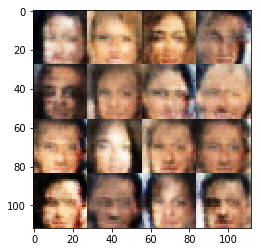

Epoch 0/1... Discriminator Loss: 0.8476... Generator Loss: 1.1305
Epoch 0/1... Discriminator Loss: 0.9620... Generator Loss: 0.7358
Epoch 0/1... Discriminator Loss: 1.1109... Generator Loss: 0.6313
Epoch 0/1... Discriminator Loss: 1.0598... Generator Loss: 1.3891
Epoch 0/1... Discriminator Loss: 1.0864... Generator Loss: 1.2065


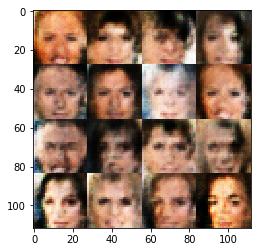

Epoch 0/1... Discriminator Loss: 1.0243... Generator Loss: 1.4497
Epoch 0/1... Discriminator Loss: 1.1151... Generator Loss: 0.6349
Epoch 0/1... Discriminator Loss: 0.7682... Generator Loss: 1.6745
Epoch 0/1... Discriminator Loss: 1.0606... Generator Loss: 0.6835
Epoch 0/1... Discriminator Loss: 0.9863... Generator Loss: 1.9382


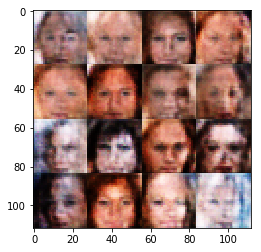

Epoch 0/1... Discriminator Loss: 0.9110... Generator Loss: 0.8771
Epoch 0/1... Discriminator Loss: 0.8400... Generator Loss: 1.4449
Epoch 0/1... Discriminator Loss: 0.7960... Generator Loss: 0.9279
Epoch 0/1... Discriminator Loss: 1.0167... Generator Loss: 1.8619
Epoch 0/1... Discriminator Loss: 0.8855... Generator Loss: 1.7149


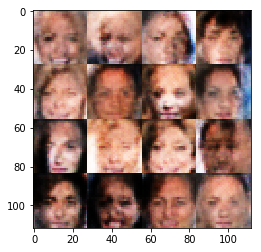

Epoch 0/1... Discriminator Loss: 1.1114... Generator Loss: 0.7105
Epoch 0/1... Discriminator Loss: 1.2637... Generator Loss: 1.0246
Epoch 0/1... Discriminator Loss: 1.0017... Generator Loss: 0.7383
Epoch 0/1... Discriminator Loss: 0.7430... Generator Loss: 1.6344
Epoch 0/1... Discriminator Loss: 0.9891... Generator Loss: 1.4546


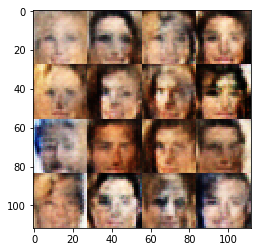

Epoch 0/1... Discriminator Loss: 0.9002... Generator Loss: 1.6058
Epoch 0/1... Discriminator Loss: 1.1408... Generator Loss: 0.6088
Epoch 0/1... Discriminator Loss: 1.0070... Generator Loss: 1.4806
Epoch 0/1... Discriminator Loss: 0.8818... Generator Loss: 1.2011
Epoch 0/1... Discriminator Loss: 0.9730... Generator Loss: 0.9380


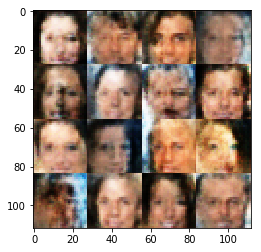

Epoch 0/1... Discriminator Loss: 0.7835... Generator Loss: 1.0841
Epoch 0/1... Discriminator Loss: 1.0721... Generator Loss: 0.8870
Epoch 0/1... Discriminator Loss: 0.8653... Generator Loss: 1.7602
Epoch 0/1... Discriminator Loss: 1.0737... Generator Loss: 1.1920
Epoch 0/1... Discriminator Loss: 1.3429... Generator Loss: 0.4584


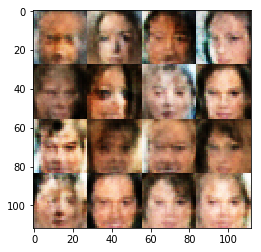

Epoch 0/1... Discriminator Loss: 1.1006... Generator Loss: 0.7438
Epoch 0/1... Discriminator Loss: 0.7833... Generator Loss: 1.1142
Epoch 0/1... Discriminator Loss: 0.9064... Generator Loss: 1.6255
Epoch 0/1... Discriminator Loss: 1.4912... Generator Loss: 1.9142
Epoch 0/1... Discriminator Loss: 1.0269... Generator Loss: 1.1756


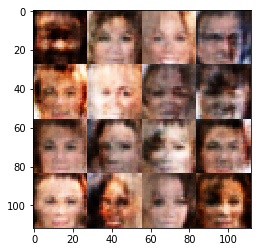

Epoch 0/1... Discriminator Loss: 0.9017... Generator Loss: 0.9002
Epoch 0/1... Discriminator Loss: 0.6975... Generator Loss: 1.7622
Epoch 0/1... Discriminator Loss: 0.8982... Generator Loss: 1.1957
Epoch 0/1... Discriminator Loss: 1.0184... Generator Loss: 0.8749
Epoch 0/1... Discriminator Loss: 1.1881... Generator Loss: 0.6525


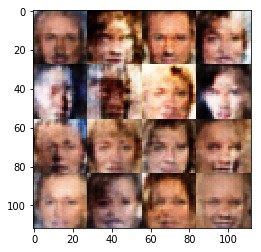

Epoch 0/1... Discriminator Loss: 0.8678... Generator Loss: 1.1055
Epoch 0/1... Discriminator Loss: 1.4582... Generator Loss: 0.3577
Epoch 0/1... Discriminator Loss: 1.0126... Generator Loss: 1.1568
Epoch 0/1... Discriminator Loss: 1.0174... Generator Loss: 1.1841
Epoch 0/1... Discriminator Loss: 0.8846... Generator Loss: 1.3134


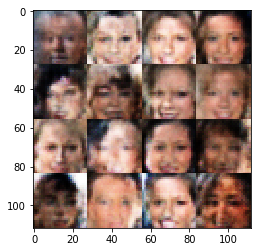

Epoch 0/1... Discriminator Loss: 0.9773... Generator Loss: 1.3685
Epoch 0/1... Discriminator Loss: 0.9020... Generator Loss: 1.1039
Epoch 0/1... Discriminator Loss: 1.0831... Generator Loss: 1.1091
Epoch 0/1... Discriminator Loss: 1.0587... Generator Loss: 0.9541
Epoch 0/1... Discriminator Loss: 0.8170... Generator Loss: 1.3631


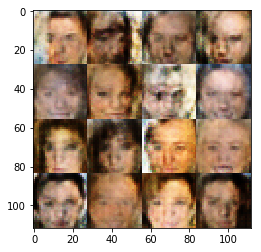

Epoch 0/1... Discriminator Loss: 0.6977... Generator Loss: 1.5973
Epoch 0/1... Discriminator Loss: 1.1118... Generator Loss: 0.5959
Epoch 0/1... Discriminator Loss: 0.9296... Generator Loss: 1.2282
Epoch 0/1... Discriminator Loss: 1.1081... Generator Loss: 0.8803
Epoch 0/1... Discriminator Loss: 0.7486... Generator Loss: 1.1497


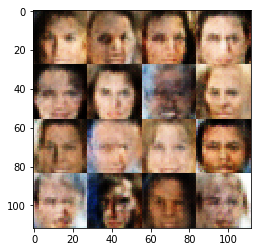

Epoch 0/1... Discriminator Loss: 1.1353... Generator Loss: 1.4667
Epoch 0/1... Discriminator Loss: 0.9671... Generator Loss: 1.0406
Epoch 0/1... Discriminator Loss: 1.0622... Generator Loss: 0.7794
Epoch 0/1... Discriminator Loss: 1.3705... Generator Loss: 0.4443
Epoch 0/1... Discriminator Loss: 0.8955... Generator Loss: 0.9375


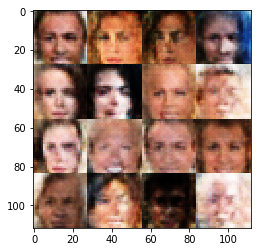

Epoch 0/1... Discriminator Loss: 1.1663... Generator Loss: 0.6688
Epoch 0/1... Discriminator Loss: 0.9318... Generator Loss: 0.8900
Epoch 0/1... Discriminator Loss: 0.9154... Generator Loss: 1.1027
Epoch 0/1... Discriminator Loss: 0.8828... Generator Loss: 1.1157
Epoch 0/1... Discriminator Loss: 1.2926... Generator Loss: 0.5252


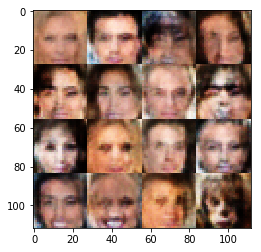

Epoch 0/1... Discriminator Loss: 1.0184... Generator Loss: 1.0521
Epoch 0/1... Discriminator Loss: 1.0266... Generator Loss: 0.8643
Epoch 0/1... Discriminator Loss: 1.0705... Generator Loss: 0.7906
Epoch 0/1... Discriminator Loss: 1.0474... Generator Loss: 1.6075
Epoch 0/1... Discriminator Loss: 1.0750... Generator Loss: 1.5141


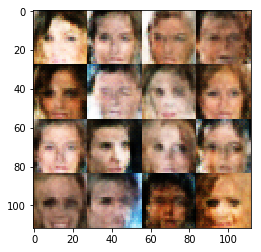

Epoch 0/1... Discriminator Loss: 0.7877... Generator Loss: 1.0977
Epoch 0/1... Discriminator Loss: 0.8007... Generator Loss: 1.2119
Epoch 0/1... Discriminator Loss: 0.9082... Generator Loss: 1.6367
Epoch 0/1... Discriminator Loss: 1.2024... Generator Loss: 0.5283
Epoch 0/1... Discriminator Loss: 1.2598... Generator Loss: 0.7007


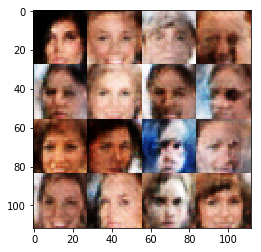

Epoch 0/1... Discriminator Loss: 1.3656... Generator Loss: 1.8270
Epoch 0/1... Discriminator Loss: 1.0523... Generator Loss: 1.1031
Epoch 0/1... Discriminator Loss: 0.9139... Generator Loss: 1.2773
Epoch 0/1... Discriminator Loss: 0.8004... Generator Loss: 0.9479
Epoch 0/1... Discriminator Loss: 1.7778... Generator Loss: 3.2027


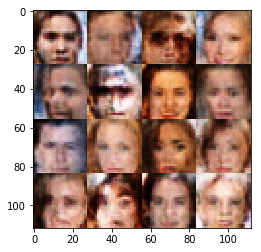

Epoch 0/1... Discriminator Loss: 1.3008... Generator Loss: 1.5471
Epoch 0/1... Discriminator Loss: 0.9953... Generator Loss: 1.2666
Epoch 0/1... Discriminator Loss: 0.9783... Generator Loss: 1.3084
Epoch 0/1... Discriminator Loss: 0.9500... Generator Loss: 1.8123
Epoch 0/1... Discriminator Loss: 0.9061... Generator Loss: 0.9391


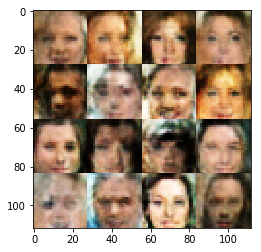

Epoch 0/1... Discriminator Loss: 1.4587... Generator Loss: 0.4236
Epoch 0/1... Discriminator Loss: 0.8771... Generator Loss: 1.1601
Epoch 0/1... Discriminator Loss: 1.0334... Generator Loss: 0.8141
Epoch 0/1... Discriminator Loss: 1.1246... Generator Loss: 0.6319
Epoch 0/1... Discriminator Loss: 1.2538... Generator Loss: 0.4997


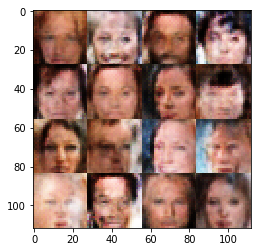

Epoch 0/1... Discriminator Loss: 0.8672... Generator Loss: 0.9646
Epoch 0/1... Discriminator Loss: 1.0828... Generator Loss: 0.6345
Epoch 0/1... Discriminator Loss: 1.0235... Generator Loss: 0.8577
Epoch 0/1... Discriminator Loss: 0.7882... Generator Loss: 1.4772
Epoch 0/1... Discriminator Loss: 0.5971... Generator Loss: 1.2227


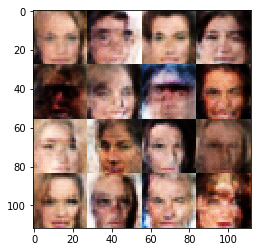

Epoch 0/1... Discriminator Loss: 0.8628... Generator Loss: 0.9749
Epoch 0/1... Discriminator Loss: 0.7004... Generator Loss: 1.3883
Epoch 0/1... Discriminator Loss: 1.2000... Generator Loss: 0.5341
Epoch 0/1... Discriminator Loss: 1.1394... Generator Loss: 2.8261
Epoch 0/1... Discriminator Loss: 0.7628... Generator Loss: 1.0487


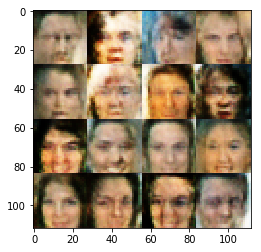

Epoch 0/1... Discriminator Loss: 0.9460... Generator Loss: 1.1455
Epoch 0/1... Discriminator Loss: 0.7637... Generator Loss: 1.3655
Epoch 0/1... Discriminator Loss: 0.9945... Generator Loss: 0.8580
Epoch 0/1... Discriminator Loss: 0.9406... Generator Loss: 1.1223
Epoch 0/1... Discriminator Loss: 0.9280... Generator Loss: 1.2932


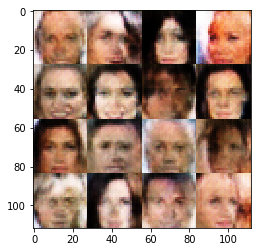

Epoch 0/1... Discriminator Loss: 1.8765... Generator Loss: 0.2293
Epoch 0/1... Discriminator Loss: 0.9933... Generator Loss: 1.0945
Epoch 0/1... Discriminator Loss: 0.9478... Generator Loss: 1.2423
Epoch 0/1... Discriminator Loss: 0.9221... Generator Loss: 1.2224
Epoch 0/1... Discriminator Loss: 1.3964... Generator Loss: 0.4040


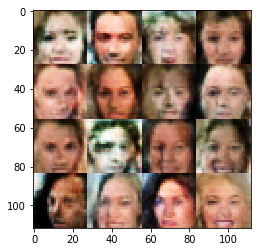

Epoch 0/1... Discriminator Loss: 0.8364... Generator Loss: 1.0703
Epoch 0/1... Discriminator Loss: 0.9174... Generator Loss: 1.9866
Epoch 0/1... Discriminator Loss: 0.9306... Generator Loss: 1.0210
Epoch 0/1... Discriminator Loss: 1.1101... Generator Loss: 0.6689
Epoch 0/1... Discriminator Loss: 1.1568... Generator Loss: 0.5282


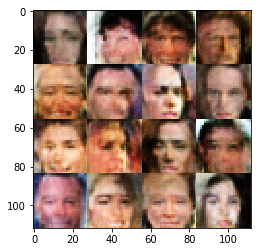

Epoch 0/1... Discriminator Loss: 1.0135... Generator Loss: 0.8591
Epoch 0/1... Discriminator Loss: 0.8413... Generator Loss: 1.4103
Epoch 0/1... Discriminator Loss: 1.2665... Generator Loss: 0.4757
Epoch 0/1... Discriminator Loss: 0.9580... Generator Loss: 1.4122
Epoch 0/1... Discriminator Loss: 0.9974... Generator Loss: 0.6953


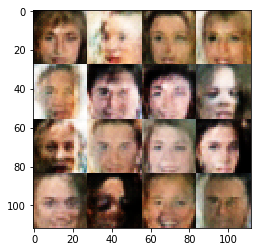

Epoch 0/1... Discriminator Loss: 0.7535... Generator Loss: 1.2253
Epoch 0/1... Discriminator Loss: 1.0254... Generator Loss: 1.5502
Epoch 0/1... Discriminator Loss: 1.0958... Generator Loss: 0.6455
Epoch 0/1... Discriminator Loss: 0.9037... Generator Loss: 0.7996
Epoch 0/1... Discriminator Loss: 0.9170... Generator Loss: 1.8795


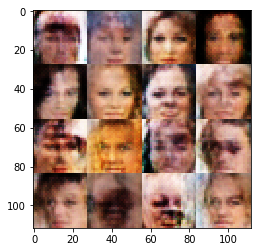

Epoch 0/1... Discriminator Loss: 1.3432... Generator Loss: 0.4790
Epoch 0/1... Discriminator Loss: 1.3320... Generator Loss: 0.4369
Epoch 0/1... Discriminator Loss: 1.0968... Generator Loss: 0.6112
Epoch 0/1... Discriminator Loss: 0.7859... Generator Loss: 1.1788
Epoch 0/1... Discriminator Loss: 0.7276... Generator Loss: 1.2614


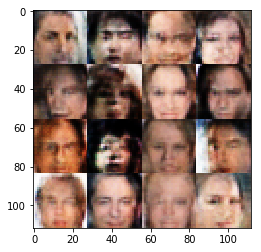

Epoch 0/1... Discriminator Loss: 0.7894... Generator Loss: 1.2057
Epoch 0/1... Discriminator Loss: 0.7519... Generator Loss: 1.0892
Epoch 0/1... Discriminator Loss: 0.9129... Generator Loss: 1.7237
Epoch 0/1... Discriminator Loss: 0.7450... Generator Loss: 1.1055
Epoch 0/1... Discriminator Loss: 1.3906... Generator Loss: 0.4236


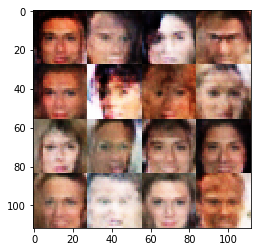

Epoch 0/1... Discriminator Loss: 0.8532... Generator Loss: 1.6531
Epoch 0/1... Discriminator Loss: 0.7167... Generator Loss: 1.2920
Epoch 0/1... Discriminator Loss: 0.6478... Generator Loss: 1.3763
Epoch 0/1... Discriminator Loss: 0.7314... Generator Loss: 1.3384
Epoch 0/1... Discriminator Loss: 1.0908... Generator Loss: 1.0529


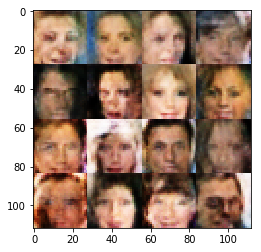

Epoch 0/1... Discriminator Loss: 1.0187... Generator Loss: 0.6947
Epoch 0/1... Discriminator Loss: 0.9358... Generator Loss: 0.6837
Epoch 0/1... Discriminator Loss: 1.2231... Generator Loss: 0.5157
Epoch 0/1... Discriminator Loss: 0.7276... Generator Loss: 1.5105
Epoch 0/1... Discriminator Loss: 0.9719... Generator Loss: 1.1160


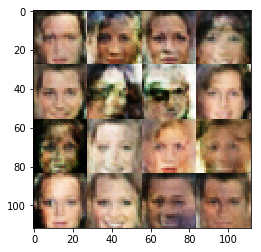

Epoch 0/1... Discriminator Loss: 0.9953... Generator Loss: 1.2662
Epoch 0/1... Discriminator Loss: 0.8068... Generator Loss: 1.5130
Epoch 0/1... Discriminator Loss: 0.9587... Generator Loss: 0.7260
Epoch 0/1... Discriminator Loss: 0.6872... Generator Loss: 1.5226
Epoch 0/1... Discriminator Loss: 1.0045... Generator Loss: 1.1793


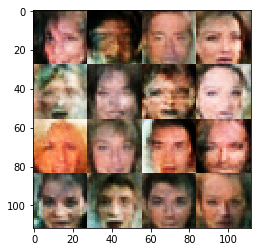

Epoch 0/1... Discriminator Loss: 0.9140... Generator Loss: 2.9558
Epoch 0/1... Discriminator Loss: 0.7341... Generator Loss: 1.5384
Epoch 0/1... Discriminator Loss: 1.5904... Generator Loss: 0.3221
Epoch 0/1... Discriminator Loss: 1.2494... Generator Loss: 0.8973
Epoch 0/1... Discriminator Loss: 0.6772... Generator Loss: 1.1047


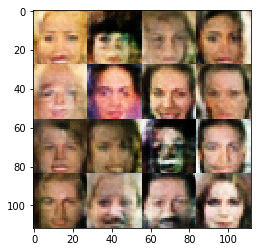

Epoch 0/1... Discriminator Loss: 0.7458... Generator Loss: 1.5512
Epoch 0/1... Discriminator Loss: 0.6696... Generator Loss: 1.2188
Epoch 0/1... Discriminator Loss: 0.6436... Generator Loss: 1.3416
Epoch 0/1... Discriminator Loss: 0.8107... Generator Loss: 1.1397
Epoch 0/1... Discriminator Loss: 1.2873... Generator Loss: 1.5315


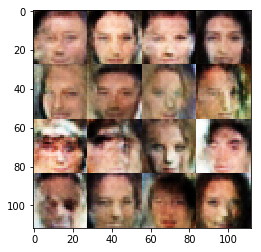

Epoch 0/1... Discriminator Loss: 0.8205... Generator Loss: 0.9451
Epoch 0/1... Discriminator Loss: 1.0484... Generator Loss: 0.5966
Epoch 0/1... Discriminator Loss: 1.0060... Generator Loss: 0.7222
Epoch 0/1... Discriminator Loss: 1.0060... Generator Loss: 1.5198
Epoch 0/1... Discriminator Loss: 0.6545... Generator Loss: 1.3019


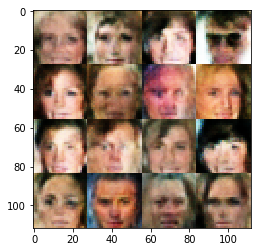

Epoch 0/1... Discriminator Loss: 1.0233... Generator Loss: 2.5120
Epoch 0/1... Discriminator Loss: 1.0759... Generator Loss: 0.5899
Epoch 0/1... Discriminator Loss: 0.9322... Generator Loss: 1.7763
Epoch 0/1... Discriminator Loss: 0.8258... Generator Loss: 1.6609
Epoch 0/1... Discriminator Loss: 0.8107... Generator Loss: 2.2690


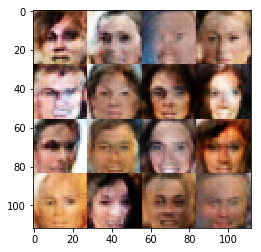

Epoch 0/1... Discriminator Loss: 1.0503... Generator Loss: 0.6934
Epoch 0/1... Discriminator Loss: 0.9309... Generator Loss: 1.4889
Epoch 0/1... Discriminator Loss: 0.6313... Generator Loss: 1.1383
Epoch 0/1... Discriminator Loss: 0.9080... Generator Loss: 0.7993
Epoch 0/1... Discriminator Loss: 1.0481... Generator Loss: 2.9401


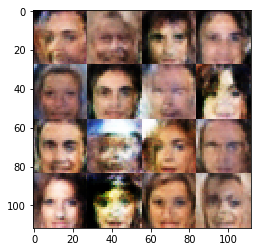

Epoch 0/1... Discriminator Loss: 0.7939... Generator Loss: 2.2930
Epoch 0/1... Discriminator Loss: 1.2260... Generator Loss: 0.5335


In [186]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.